In [1]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import random
import sys
np.random.seed(1)
max_r, max_c = 4, 4
# state_value = np.zeros((5,5))
action_set = {'AU': 0, 'AR': 1, 'AD': 2, 'AL': 3}
action_coord = [[-1,0], [0,1], [1,0], [0,-1]]
terminal_states = [[4,4]]
obstacles = [[2,2], [3,2]]
obstacle_index = [(max_r+1)*r+c for r, c in obstacles]
water = [[4,2]]
initial_states = [[0,0]]# [[i,j] for j in range(max_c+1) for i in range(max_r+1) if [i,j] not in obstacles+terminal_states]
softmax_sigma=0.1

print_arrow = {'AU': u'\u2191', 'AR': u'\u2192', 'AL': u'\u2190', 'AD': u'\u2193', 'G': 'G'}

In [2]:
def transition_function(state_r, state_c, action, prob = [0.8, 0.05, 0.05, 0.1]):
# def transition_function(state_r, state_c, action, prob = [1.0, 0.0, 0.0, 0.0]): #deterministic
    if action not in action_set:
        print("wrong action")
        sys.exit(0)
    if state_r == max_r and state_c == max_c:
        return []
    action_idx = action_set[action]
    action_idx_r = (action_idx+1)%4
    action_idx_l = (action_idx-1)%4
    # del_r, del_c = random.choices([action_coord[action_idx], action_coord[action_idx_r], action_coord[action_idx_l], [0,0]], weights=[0.8, 0.05, 0.05, 0.1])
    future_states = []
    temp = [action_coord[action_idx], action_coord[action_idx_r], action_coord[action_idx_l], [0,0]]
    for i in range(4):
        del_r, del_c = temp[i]
        new_state_r, new_state_c = state_r, state_c
        if 0<=state_r + del_r <= max_r:
            new_state_r += del_r
        if 0<=state_c + del_c <= max_c:
            new_state_c += del_c
        if [new_state_r, new_state_c] in obstacles:
            new_state_r, new_state_c = state_r, state_c
        future_states.append([new_state_r, new_state_c, prob[i]]) 
    return future_states

In [3]:
def reward(next_state, gold_state_reward=5):
    if next_state in terminal_states:
        return 10
    if next_state in water:
        return -10    
    return 0

def softmax_select(theta, phi, state_idx):
    phi_s = phi[state_idx].T
    # print(phi_s.shape, theta)
    action_values = softmax_sigma*np.dot(phi_s, theta)
    policy = np.exp(action_values)
    policy /= sum(policy)
    return policy

In [4]:
def runEpisode(theta, phi):
    curr_state = random.choices(initial_states)[0]
    state_list, action_list, reward_list = [], [], []
    timestep = 0
    while curr_state not in terminal_states:# and timestep < 10000:
        state_idx = (max_r+1)*curr_state[0] + curr_state[1]
        action_idx = np.argmax(softmax_select(theta, phi, state_idx))
        curr_action = list(action_set.keys())[action_idx]
        
        possible_next_states = transition_function(curr_state[0], curr_state[1], curr_action)
        next_state = random.choices([[s[0], s[1]] for s in possible_next_states], [s[2] for s in possible_next_states])[0]
        curr_reward = reward(next_state)
        # print(curr_state, curr_action, curr_reward, next_state)
        state_list.append(curr_state)
        action_list.append(curr_action)
        #append discounted reward
        reward_list.append(curr_reward)
        curr_state = next_state
        timestep += 1

    return state_list, action_list, reward_list

In [5]:
def REINFORCE(gamma, alpha_w, alpha_theta, algo_type = 'without_baseline'):
    total_states = (max_r+1)*(max_c+1)# - len(obstacles)
    theta = np.random.normal(0, 0.1, (total_states, len(action_set))) #np.ones((total_states, len(action_set)))*0.01 #
    # momentum, vel = np.zeros(theta.shape), np.zeros(theta.shape)
    # beta1, beta2 = 0.9, 0.999
    val_w = np.zeros((total_states))
    phi = np.zeros((total_states, total_states))
    np.fill_diagonal(phi, 1.0)
    epsiodes_graph = []
    threshold = 0.9
    
    for iter in range(2000):
        state_list, action_list, reward_list = runEpisode(theta, phi)
        T = len(reward_list)
        # if iter%100==0:
        print("\n EPISODE LENGTH: ",len(reward_list), "CURR ITER: ", iter)
        return_list = np.zeros(T)
        return_list[-1] = reward_list[-1]
        for t in range(T-2, -1, -1):
            return_list[t] = reward_list[t] + gamma*return_list[t+1]
        epsiodes_graph.append(T)
        T_range = np.arange(T)
        # np.random.shuffle(T_range)
        theta_temp = theta.copy()
        for t in T_range:
            
            curr_state, curr_action = state_list[t], action_list[t]
            state_idx = (max_r+1)*curr_state[0] + curr_state[1]
            action_idx = action_set[curr_action]
            phi_s = phi[state_idx]
            if algo_type == 'without_baseline':
                delta = return_list[t]
            elif algo_type == 'with_baseline':
                delta = return_list[t] - np.dot(phi_s, val_w)
            #w update
            #theta update
            
            policy = softmax_select(theta, phi, state_idx)
            for i in range(len(action_set)):
                if action_idx == i:
                    theta[:, i] += alpha_theta*delta*(1-policy[action_idx])*phi_s
                else:
                    theta[:, i] += alpha_theta*delta*(-1*policy[action_idx])*phi_s
            # print(action_idx, delta, policy)
            
            if algo_type == 'with_baseline':
                val_w += alpha_w*delta*phi_s
            #adam update
            # momentum = beta1*momentum + (1-beta1)*delta*delta_ln_pi
            # vel = beta2*vel + (1-beta2)*(delta*delta_ln_pi)**2
            # delta_theta = alpha_theta*momentum/(1-beta1)/(np.sqrt(vel/(1 - beta2)) + 10**(-8))

        #relative change in theta
        max_diff = np.max(np.abs(theta_temp - theta))
        print("max_diff ", max_diff)
        if  max_diff/alpha_theta < threshold:
            break


            
    #final policy
    greedy_policy = [[None for i in range(max_c+1)] for j in range(max_r+1)]
    for i in range(max_r+1):
        for j in range(max_c+1):
            if [i,j] in terminal_states:
                greedy_policy[i][j] = 'G'
                continue
            if [i,j] in obstacles:
                continue
            state_idx = (max_r+1)*i + j
            policy = softmax_select(theta, phi, state_idx)
            action_idx = np.argmax(policy)
            greedy_policy[i][j] = list(action_set.keys())[action_idx]

    # print(greedy_policy)
    print("final policy ")
    for r in greedy_policy:
        s = ''
        for dir in r:
            if dir in print_arrow:
                s += print_arrow[dir] +'  '
            else:
                s += '   '
        print(s)

    plt.figure()
    plt.plot(np.arange(len(epsiodes_graph)), epsiodes_graph)
    plt.xlabel('Iterations')
    plt.ylabel('#Episodes')
    # plt.ylim([-100, 1000])
    plt.savefig('graph_gridworld_reinforce_'+str(algo_type))


 EPISODE LENGTH:  173 CURR ITER:  0
max_diff  4.6011284982050427e-07

 EPISODE LENGTH:  121 CURR ITER:  1
max_diff  6.364740040565309e-07

 EPISODE LENGTH:  429 CURR ITER:  2
max_diff  6.013123065029546e-07

 EPISODE LENGTH:  121 CURR ITER:  3
max_diff  2.575385583680756e-07

 EPISODE LENGTH:  82 CURR ITER:  4
max_diff  6.434344675260162e-07

 EPISODE LENGTH:  455 CURR ITER:  5
max_diff  1.6007266329207126e-05

 EPISODE LENGTH:  159 CURR ITER:  6
max_diff  5.138709592011903e-07

 EPISODE LENGTH:  114 CURR ITER:  7
max_diff  6.101079712134139e-07

 EPISODE LENGTH:  145 CURR ITER:  8
max_diff  6.951145619660259e-07

 EPISODE LENGTH:  254 CURR ITER:  9
max_diff  3.6594356740693446e-07

 EPISODE LENGTH:  202 CURR ITER:  10
max_diff  3.5089269133370404e-07

 EPISODE LENGTH:  125 CURR ITER:  11
max_diff  7.05329249131581e-07

 EPISODE LENGTH:  44 CURR ITER:  12
max_diff  3.5089267889920617e-07

 EPISODE LENGTH:  240 CURR ITER:  13
max_diff  3.906910251844087e-07

 EPISODE LENGTH:  99 CURR I


 EPISODE LENGTH:  255 CURR ITER:  119
max_diff  7.461783070872308e-07

 EPISODE LENGTH:  265 CURR ITER:  120
max_diff  5.585210546693586e-07

 EPISODE LENGTH:  242 CURR ITER:  121
max_diff  2.1833814463079193e-05

 EPISODE LENGTH:  185 CURR ITER:  122
max_diff  5.692689831332531e-07

 EPISODE LENGTH:  743 CURR ITER:  123
max_diff  4.877707284051125e-07

 EPISODE LENGTH:  195 CURR ITER:  124
max_diff  5.671853875871546e-07

 EPISODE LENGTH:  530 CURR ITER:  125
max_diff  6.476238703922998e-07

 EPISODE LENGTH:  188 CURR ITER:  126
max_diff  3.509121465350429e-07

 EPISODE LENGTH:  103 CURR ITER:  127
max_diff  6.239837274518711e-07

 EPISODE LENGTH:  498 CURR ITER:  128
max_diff  4.3531133195329197e-07

 EPISODE LENGTH:  118 CURR ITER:  129
max_diff  4.108323093943156e-07

 EPISODE LENGTH:  117 CURR ITER:  130
max_diff  5.9468822417863e-07

 EPISODE LENGTH:  167 CURR ITER:  131
max_diff  4.5392369582564207e-07

 EPISODE LENGTH:  86 CURR ITER:  132
max_diff  3.066717640526351e-07

 EPIS

max_diff  6.75126869256748e-07

 EPISODE LENGTH:  371 CURR ITER:  239
max_diff  1.469882811087897e-05

 EPISODE LENGTH:  84 CURR ITER:  240
max_diff  6.948760504776885e-07

 EPISODE LENGTH:  101 CURR ITER:  241
max_diff  5.859349269526914e-07

 EPISODE LENGTH:  281 CURR ITER:  242
max_diff  3.246581581350938e-07

 EPISODE LENGTH:  301 CURR ITER:  243
max_diff  3.160185752873468e-07

 EPISODE LENGTH:  227 CURR ITER:  244
max_diff  3.066712834370877e-07

 EPISODE LENGTH:  193 CURR ITER:  245
max_diff  5.95149060547695e-07

 EPISODE LENGTH:  248 CURR ITER:  246
max_diff  2.575376700786336e-07

 EPISODE LENGTH:  383 CURR ITER:  247
max_diff  6.969982648680206e-07

 EPISODE LENGTH:  175 CURR ITER:  248
max_diff  6.825014727124268e-07

 EPISODE LENGTH:  333 CURR ITER:  249
max_diff  3.674314383306232e-07

 EPISODE LENGTH:  341 CURR ITER:  250
max_diff  4.821751499600735e-07

 EPISODE LENGTH:  328 CURR ITER:  251
max_diff  2.575376509411642e-07

 EPISODE LENGTH:  272 CURR ITER:  252
max_diff 

max_diff  3.29341714802589e-07

 EPISODE LENGTH:  261 CURR ITER:  360
max_diff  5.58519199125862e-07

 EPISODE LENGTH:  175 CURR ITER:  361
max_diff  5.412973380358732e-07

 EPISODE LENGTH:  130 CURR ITER:  362
max_diff  2.5753726345945083e-07

 EPISODE LENGTH:  109 CURR ITER:  363
max_diff  2.490451644898955e-07

 EPISODE LENGTH:  373 CURR ITER:  364
max_diff  3.886452679957575e-07

 EPISODE LENGTH:  266 CURR ITER:  365
max_diff  7.032567199694029e-07

 EPISODE LENGTH:  221 CURR ITER:  366
max_diff  6.825004181532091e-07

 EPISODE LENGTH:  344 CURR ITER:  367
max_diff  6.709301216267782e-07

 EPISODE LENGTH:  172 CURR ITER:  368
max_diff  5.084160081825218e-07

 EPISODE LENGTH:  377 CURR ITER:  369
max_diff  3.90689077492401e-07

 EPISODE LENGTH:  121 CURR ITER:  370
max_diff  4.484621348999074e-07

 EPISODE LENGTH:  152 CURR ITER:  371
max_diff  5.138683229627405e-07

 EPISODE LENGTH:  61 CURR ITER:  372
max_diff  2.591064694607015e-07

 EPISODE LENGTH:  163 CURR ITER:  373
max_diff 


 EPISODE LENGTH:  265 CURR ITER:  488
max_diff  4.5963613538868575e-07

 EPISODE LENGTH:  75 CURR ITER:  489
max_diff  6.751245981706511e-07

 EPISODE LENGTH:  169 CURR ITER:  490
max_diff  3.9259610848385584e-07

 EPISODE LENGTH:  127 CURR ITER:  491
max_diff  6.634639398012121e-07

 EPISODE LENGTH:  474 CURR ITER:  492
max_diff  3.906884385868059e-07

 EPISODE LENGTH:  110 CURR ITER:  493
max_diff  5.373678622355715e-07

 EPISODE LENGTH:  392 CURR ITER:  494
max_diff  7.171256780624802e-07

 EPISODE LENGTH:  158 CURR ITER:  495
max_diff  3.9899394731202076e-07

 EPISODE LENGTH:  161 CURR ITER:  496
max_diff  4.187689394835603e-07

 EPISODE LENGTH:  230 CURR ITER:  497
max_diff  4.748713365032575e-07

 EPISODE LENGTH:  111 CURR ITER:  498
max_diff  7.28042913775151e-07

 EPISODE LENGTH:  237 CURR ITER:  499
max_diff  3.508903092530602e-07

 EPISODE LENGTH:  220 CURR ITER:  500
max_diff  4.679045271516191e-07

 EPISODE LENGTH:  371 CURR ITER:  501
max_diff  3.867268381502198e-07

 EPI

 EPISODE LENGTH:  273 CURR ITER:  615
max_diff  5.16222295895985e-07

 EPISODE LENGTH:  90 CURR ITER:  616
max_diff  6.573886734972945e-07

 EPISODE LENGTH:  337 CURR ITER:  617
max_diff  7.10411289184254e-07

 EPISODE LENGTH:  223 CURR ITER:  618
max_diff  4.265059625474521e-07

 EPISODE LENGTH:  528 CURR ITER:  619
max_diff  2.5198219152922086e-07

 EPISODE LENGTH:  120 CURR ITER:  620
max_diff  3.4809623661313793e-07

 EPISODE LENGTH:  501 CURR ITER:  621
max_diff  4.33056604978721e-07

 EPISODE LENGTH:  363 CURR ITER:  622
max_diff  2.838266935506484e-07

 EPISODE LENGTH:  362 CURR ITER:  623
max_diff  7.382557784818555e-07

 EPISODE LENGTH:  319 CURR ITER:  624
max_diff  3.9492501807680824e-07

 EPISODE LENGTH:  480 CURR ITER:  625
max_diff  4.5226699502132206e-07

 EPISODE LENGTH:  97 CURR ITER:  626
max_diff  2.0831526201942063e-07

 EPISODE LENGTH:  163 CURR ITER:  627
max_diff  6.244723072534875e-07

 EPISODE LENGTH:  88 CURR ITER:  628
max_diff  4.877550532078612e-07

 EPISOD

 EPISODE LENGTH:  133 CURR ITER:  744
max_diff  3.7416150167057793e-07

 EPISODE LENGTH:  204 CURR ITER:  745
max_diff  4.197142374831597e-07

 EPISODE LENGTH:  133 CURR ITER:  746
max_diff  2.5753590411625726e-07

 EPISODE LENGTH:  450 CURR ITER:  747
max_diff  5.614207502779855e-07

 EPISODE LENGTH:  91 CURR ITER:  748
max_diff  5.246298973721197e-07

 EPISODE LENGTH:  155 CURR ITER:  749
max_diff  6.364673893199946e-07

 EPISODE LENGTH:  519 CURR ITER:  750
max_diff  4.280175648352369e-07

 EPISODE LENGTH:  193 CURR ITER:  751
max_diff  6.239783504752294e-07

 EPISODE LENGTH:  413 CURR ITER:  752
max_diff  3.107305078381417e-07

 EPISODE LENGTH:  520 CURR ITER:  753
max_diff  6.192291188422683e-07

 EPISODE LENGTH:  202 CURR ITER:  754
max_diff  4.2650515363895636e-07

 EPISODE LENGTH:  71 CURR ITER:  755
max_diff  4.733820453545201e-07

 EPISODE LENGTH:  174 CURR ITER:  756
max_diff  2.5758622605731585e-07

 EPISODE LENGTH:  181 CURR ITER:  757
max_diff  5.082424071184422e-07

 EPI

max_diff  3.9068644168416267e-07

 EPISODE LENGTH:  326 CURR ITER:  863
max_diff  5.176950954033366e-07

 EPISODE LENGTH:  96 CURR ITER:  864
max_diff  5.373651119078282e-07

 EPISODE LENGTH:  79 CURR ITER:  865
max_diff  3.508885448311183e-07

 EPISODE LENGTH:  463 CURR ITER:  866
max_diff  7.018622616011827e-07

 EPISODE LENGTH:  47 CURR ITER:  867
max_diff  5.775505113325696e-07

 EPISODE LENGTH:  38 CURR ITER:  868
max_diff  5.946821822894188e-07

 EPISODE LENGTH:  103 CURR ITER:  869
max_diff  3.9962230422019296e-07

 EPISODE LENGTH:  377 CURR ITER:  870
max_diff  4.877534194314137e-07

 EPISODE LENGTH:  98 CURR ITER:  871
max_diff  3.906863873387456e-07

 EPISODE LENGTH:  70 CURR ITER:  872
max_diff  2.5839035044938896e-07

 EPISODE LENGTH:  200 CURR ITER:  873
max_diff  4.2197606035798696e-07

 EPISODE LENGTH:  132 CURR ITER:  874
max_diff  3.5088850060260857e-07

 EPISODE LENGTH:  468 CURR ITER:  875
max_diff  5.45932300671792e-07

 EPISODE LENGTH:  110 CURR ITER:  876
max_diff

max_diff  3.0666815831192906e-07

 EPISODE LENGTH:  253 CURR ITER:  989
max_diff  4.890033180951492e-07

 EPISODE LENGTH:  153 CURR ITER:  990
max_diff  4.587400228295291e-07

 EPISODE LENGTH:  165 CURR ITER:  991
max_diff  6.669259061675703e-07

 EPISODE LENGTH:  177 CURR ITER:  992
max_diff  7.147048104866327e-07

 EPISODE LENGTH:  180 CURR ITER:  993
max_diff  3.508879249797259e-07

 EPISODE LENGTH:  158 CURR ITER:  994
max_diff  5.464140772626358e-07

 EPISODE LENGTH:  349 CURR ITER:  995
max_diff  4.865361521305678e-07

 EPISODE LENGTH:  380 CURR ITER:  996
max_diff  6.067795230296769e-07

 EPISODE LENGTH:  82 CURR ITER:  997
max_diff  3.9068571060230095e-07

 EPISODE LENGTH:  775 CURR ITER:  998
max_diff  7.102213009230196e-07

 EPISODE LENGTH:  855 CURR ITER:  999
max_diff  6.578213443825254e-07

 EPISODE LENGTH:  668 CURR ITER:  1000
max_diff  5.007460935901875e-07

 EPISODE LENGTH:  88 CURR ITER:  1001
max_diff  4.228674195944082e-07

 EPISODE LENGTH:  232 CURR ITER:  1002
max

max_diff  5.946801796136159e-07

 EPISODE LENGTH:  198 CURR ITER:  1111
max_diff  7.053184946786972e-07

 EPISODE LENGTH:  101 CURR ITER:  1112
max_diff  6.034457230852386e-07

 EPISODE LENGTH:  32 CURR ITER:  1113
max_diff  2.0294234960582802e-07

 EPISODE LENGTH:  194 CURR ITER:  1114
max_diff  7.161813870004696e-07

 EPISODE LENGTH:  119 CURR ITER:  1115
max_diff  5.60965569385008e-07

 EPISODE LENGTH:  229 CURR ITER:  1116
max_diff  6.48132720174055e-07

 EPISODE LENGTH:  125 CURR ITER:  1117
max_diff  2.57534576733609e-07

 EPISODE LENGTH:  367 CURR ITER:  1118
max_diff  6.578202410290057e-07

 EPISODE LENGTH:  278 CURR ITER:  1119
max_diff  5.432475669447934e-07

 EPISODE LENGTH:  92 CURR ITER:  1120
max_diff  2.933525295178985e-07

 EPISODE LENGTH:  225 CURR ITER:  1121
max_diff  5.957705042775041e-07

 EPISODE LENGTH:  152 CURR ITER:  1122
max_diff  2.2723768169658626e-07

 EPISODE LENGTH:  476 CURR ITER:  1123
max_diff  4.2650297765733924e-07

 EPISODE LENGTH:  159 CURR ITER: 

 EPISODE LENGTH:  134 CURR ITER:  1237
max_diff  5.356712302756472e-07

 EPISODE LENGTH:  694 CURR ITER:  1238
max_diff  6.191890896692365e-06

 EPISODE LENGTH:  126 CURR ITER:  1239
max_diff  3.2934117751709513e-07

 EPISODE LENGTH:  178 CURR ITER:  1240
max_diff  5.291439336696513e-07

 EPISODE LENGTH:  406 CURR ITER:  1241
max_diff  3.0666706944681987e-07

 EPISODE LENGTH:  112 CURR ITER:  1242
max_diff  4.765332516920573e-07

 EPISODE LENGTH:  45 CURR ITER:  1243
max_diff  2.0287660786738604e-07

 EPISODE LENGTH:  370 CURR ITER:  1244
max_diff  5.1386215127458e-07

 EPISODE LENGTH:  150 CURR ITER:  1245
max_diff  4.172210276154331e-07

 EPISODE LENGTH:  451 CURR ITER:  1246
max_diff  4.058360177638942e-07

 EPISODE LENGTH:  216 CURR ITER:  1247
max_diff  5.724230836279265e-07

 EPISODE LENGTH:  97 CURR ITER:  1248
max_diff  2.662081755619265e-07

 EPISODE LENGTH:  130 CURR ITER:  1249
max_diff  7.269779978280599e-07

 EPISODE LENGTH:  226 CURR ITER:  1250
max_diff  5.65156809073652

max_diff  4.3793339113418206e-07

 EPISODE LENGTH:  147 CURR ITER:  1354
max_diff  7.175189095653955e-07

 EPISODE LENGTH:  104 CURR ITER:  1355
max_diff  3.5088615936429424e-07

 EPISODE LENGTH:  243 CURR ITER:  1356
max_diff  3.469096482161538e-07

 EPISODE LENGTH:  264 CURR ITER:  1357
max_diff  3.5088615113476607e-07

 EPISODE LENGTH:  122 CURR ITER:  1358
max_diff  4.304478411765178e-07

 EPISODE LENGTH:  87 CURR ITER:  1359
max_diff  3.508861419615483e-07

 EPISODE LENGTH:  394 CURR ITER:  1360
max_diff  5.833179684555656e-07

 EPISODE LENGTH:  265 CURR ITER:  1361
max_diff  6.050297604587307e-07

 EPISODE LENGTH:  93 CURR ITER:  1362
max_diff  3.5070180466612033e-07

 EPISODE LENGTH:  357 CURR ITER:  1363
max_diff  2.439415352566924e-07

 EPISODE LENGTH:  84 CURR ITER:  1364
max_diff  2.0294165820056165e-07

 EPISODE LENGTH:  104 CURR ITER:  1365
max_diff  3.066665599099627e-07

 EPISODE LENGTH:  278 CURR ITER:  1366
max_diff  2.283342045237679e-07

 EPISODE LENGTH:  138 CURR IT

max_diff  4.471680089615515e-07

 EPISODE LENGTH:  178 CURR ITER:  1474
max_diff  6.352637273582262e-07

 EPISODE LENGTH:  450 CURR ITER:  1475
max_diff  4.265008991255481e-07

 EPISODE LENGTH:  158 CURR ITER:  1476
max_diff  4.877493122862342e-07

 EPISODE LENGTH:  139 CURR ITER:  1477
max_diff  6.100955305815559e-07

 EPISODE LENGTH:  269 CURR ITER:  1478
max_diff  4.7170184741540666e-07

 EPISODE LENGTH:  278 CURR ITER:  1479
max_diff  4.488079493325525e-07

 EPISODE LENGTH:  213 CURR ITER:  1480
max_diff  7.319903085195589e-07

 EPISODE LENGTH:  493 CURR ITER:  1481
max_diff  5.58510530032641e-07

 EPISODE LENGTH:  216 CURR ITER:  1482
max_diff  4.98053656941555e-07

 EPISODE LENGTH:  111 CURR ITER:  1483
max_diff  4.1655063330592323e-07

 EPISODE LENGTH:  283 CURR ITER:  1484
max_diff  7.294482247816036e-07

 EPISODE LENGTH:  470 CURR ITER:  1485
max_diff  6.80818411563644e-07

 EPISODE LENGTH:  141 CURR ITER:  1486
max_diff  6.510616629429311e-07

 EPISODE LENGTH:  516 CURR ITER:


 EPISODE LENGTH:  404 CURR ITER:  1597
max_diff  4.2960069328301653e-07

 EPISODE LENGTH:  206 CURR ITER:  1598
max_diff  3.116179574519373e-07

 EPISODE LENGTH:  102 CURR ITER:  1599
max_diff  4.540760453197734e-07

 EPISODE LENGTH:  101 CURR ITER:  1600
max_diff  5.583329418870631e-07

 EPISODE LENGTH:  229 CURR ITER:  1601
max_diff  6.578158858044914e-07

 EPISODE LENGTH:  277 CURR ITER:  1602
max_diff  1.4798460535522806e-06

 EPISODE LENGTH:  72 CURR ITER:  1603
max_diff  7.171147001494571e-07

 EPISODE LENGTH:  218 CURR ITER:  1604
max_diff  3.7151925122436147e-07

 EPISODE LENGTH:  292 CURR ITER:  1605
max_diff  3.508849563960137e-07

 EPISODE LENGTH:  459 CURR ITER:  1606
max_diff  6.59281755049923e-07

 EPISODE LENGTH:  362 CURR ITER:  1607
max_diff  7.212800749584192e-07

 EPISODE LENGTH:  192 CURR ITER:  1608
max_diff  7.398939267933002e-07

 EPISODE LENGTH:  70 CURR ITER:  1609
max_diff  5.138595533249468e-07

 EPISODE LENGTH:  98 CURR ITER:  1610
max_diff  4.7650325726844

max_diff  6.187211895325451e-07

 EPISODE LENGTH:  232 CURR ITER:  1712
max_diff  3.8257499590521604e-07

 EPISODE LENGTH:  189 CURR ITER:  1713
max_diff  4.848423835052129e-07

 EPISODE LENGTH:  138 CURR ITER:  1714
max_diff  2.0272047595031213e-07

 EPISODE LENGTH:  492 CURR ITER:  1715
max_diff  4.129001636571372e-07

 EPISODE LENGTH:  241 CURR ITER:  1716
max_diff  6.364588800988891e-07

 EPISODE LENGTH:  180 CURR ITER:  1717
max_diff  2.0639628357521644e-06

 EPISODE LENGTH:  141 CURR ITER:  1718
max_diff  3.005629548649691e-07

 EPISODE LENGTH:  228 CURR ITER:  1719
max_diff  6.36458862182665e-07

 EPISODE LENGTH:  115 CURR ITER:  1720
max_diff  4.877476815906556e-07

 EPISODE LENGTH:  324 CURR ITER:  1721
max_diff  6.83954383892682e-07

 EPISODE LENGTH:  150 CURR ITER:  1722
max_diff  5.775436658639332e-07

 EPISODE LENGTH:  104 CURR ITER:  1723
max_diff  4.26499442041095e-07

 EPISODE LENGTH:  223 CURR ITER:  1724
max_diff  4.925472788380736e-07

 EPISODE LENGTH:  102 CURR ITER


 EPISODE LENGTH:  308 CURR ITER:  1832
max_diff  7.339097621017476e-07

 EPISODE LENGTH:  228 CURR ITER:  1833
max_diff  4.877469302333459e-07

 EPISODE LENGTH:  284 CURR ITER:  1834
max_diff  3.066645648946986e-07

 EPISODE LENGTH:  88 CURR ITER:  1835
max_diff  4.587346505990908e-07

 EPISODE LENGTH:  171 CURR ITER:  1836
max_diff  6.442453008848048e-07

 EPISODE LENGTH:  246 CURR ITER:  1837
max_diff  4.935233999803224e-07

 EPISODE LENGTH:  129 CURR ITER:  1838
max_diff  3.508838251758961e-07

 EPISODE LENGTH:  53 CURR ITER:  1839
max_diff  6.239689926967884e-07

 EPISODE LENGTH:  258 CURR ITER:  1840
max_diff  2.575320156850136e-07

 EPISODE LENGTH:  303 CURR ITER:  1841
max_diff  3.782795409551509e-08

 EPISODE LENGTH:  117 CURR ITER:  1842
max_diff  7.356313259376801e-07

 EPISODE LENGTH:  264 CURR ITER:  1843
max_diff  3.1672562542106597e-07

 EPISODE LENGTH:  101 CURR ITER:  1844
max_diff  4.587346016382554e-07

 EPISODE LENGTH:  174 CURR ITER:  1845
max_diff  6.8502293715244


 EPISODE LENGTH:  330 CURR ITER:  1958
max_diff  2.8689161119541465e-07

 EPISODE LENGTH:  225 CURR ITER:  1959
max_diff  4.5873392685857883e-07

 EPISODE LENGTH:  343 CURR ITER:  1960
max_diff  5.380506665070284e-07

 EPISODE LENGTH:  488 CURR ITER:  1961
max_diff  6.47918563370653e-07

 EPISODE LENGTH:  168 CURR ITER:  1962
max_diff  5.485969499230414e-07

 EPISODE LENGTH:  161 CURR ITER:  1963
max_diff  6.474953837751207e-07

 EPISODE LENGTH:  344 CURR ITER:  1964
max_diff  3.6889610173507226e-07

 EPISODE LENGTH:  145 CURR ITER:  1965
max_diff  3.9498611995036903e-07

 EPISODE LENGTH:  189 CURR ITER:  1966
max_diff  5.06080530815467e-07

 EPISODE LENGTH:  152 CURR ITER:  1967
max_diff  4.5898139129640914e-07

 EPISODE LENGTH:  193 CURR ITER:  1968
max_diff  3.702515767728398e-07

 EPISODE LENGTH:  177 CURR ITER:  1969
max_diff  5.122040534349948e-07

 EPISODE LENGTH:  228 CURR ITER:  1970
max_diff  1.4563162724218204e-06

 EPISODE LENGTH:  163 CURR ITER:  1971
max_diff  6.47684084

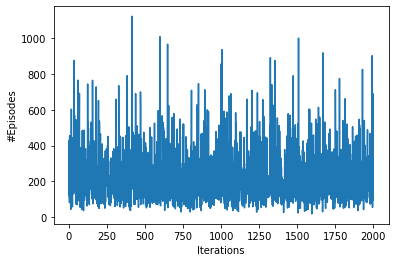

In [6]:
alpha_w, alpha_theta = 0.0001, 1e-8
REINFORCE(0.9, alpha_w, alpha_theta, 'without_baseline')